In [17]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

In [18]:
# Load the data
data = []
label = []
IMG_SIZE = 32
prefix_path = "./Train/"
sub_paths = [str(i) for i in range(43)]
for sub_path in sub_paths:
    path = prefix_path + sub_path + "/"
    number = 0
    for file in os.listdir(path):
        img = cv.imread(path + file)
        img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')
        label.append(int(sub_path))
        data.append(img)
        number += 1
        if number > 200: break
data = np.array(data)

data_label = np.array([int(i) for i in label])

In [19]:
# Normalize the data
data = data / 255.0

from sklearn.model_selection import train_test_split
nb_classes=43
X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.2, random_state=42)
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x = Input(shape=(32, 32, 3))
# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)
conv1_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv1_3)
conv1_4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
h = MaxPooling2D(pool_size=(2, 2))(conv1_4)

# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
conv2_4 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
up4 = UpSampling2D((2, 2))(conv2_4)
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# print the structure of the model
print(autoencoder.summary())

6914 train samples
1729 test samples
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)   

In [20]:
# Train the model
epochs = 50
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1,
                          validation_data=(X_test, X_test))

conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)


Epoch 1/50
55/55 [==============================] - 9s 158ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 2/50
55/55 [==============================] - 9s 171ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 3/50
55/55 [==============================] - 9s 158ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 4/50
55/55 [==============================] - 9s 158ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 5/50
55/55 [==============================] - 9s 164ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 6/50
55/55 [==============================] - 9s 167ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 7/50
55/55 [==============================] - 9s 157ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 8/50
55/55 [==============================] - 8s 145ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 9/50
55/55 [==============================] - 8s 152ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 10/50
55/55 [==============================] - 10s 186ms/step - loss: 0.6924 - val_loss: 0.692

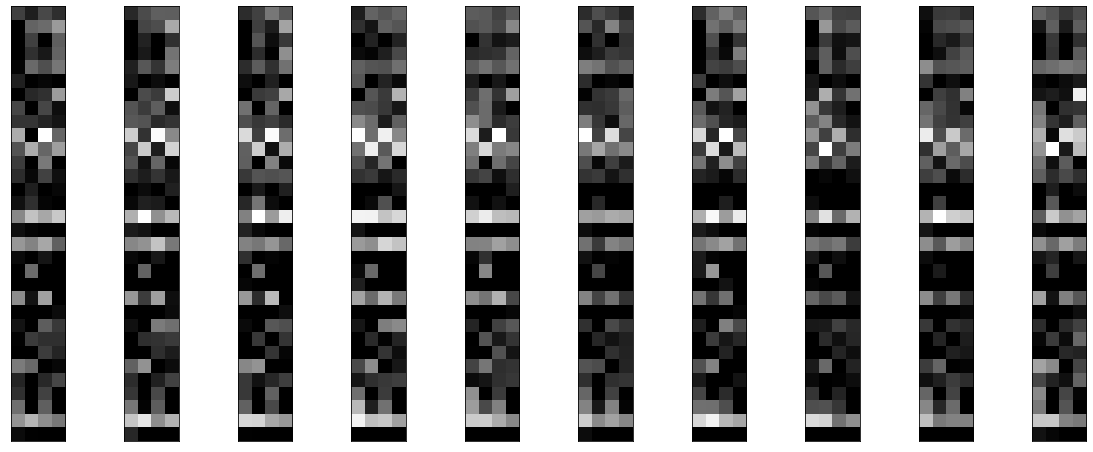

In [21]:
# show encoded images
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 32).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

55/55 [==============================] - 1s 18ms/step


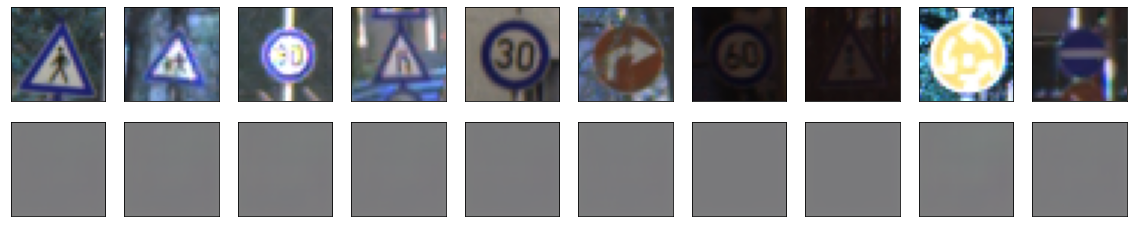

dict_keys(['loss', 'val_loss'])


In [22]:
# Predict on the test set
decoded_imgs = autoencoder.predict(X_test)

# Plot
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

print(history.history.keys())

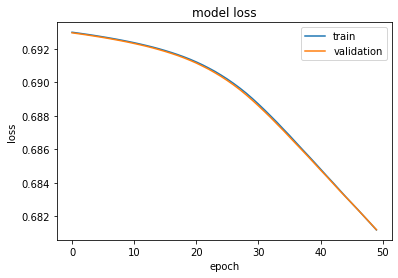

In [23]:
# Plot the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

271/271 [==============================] - 5s 19ms/step


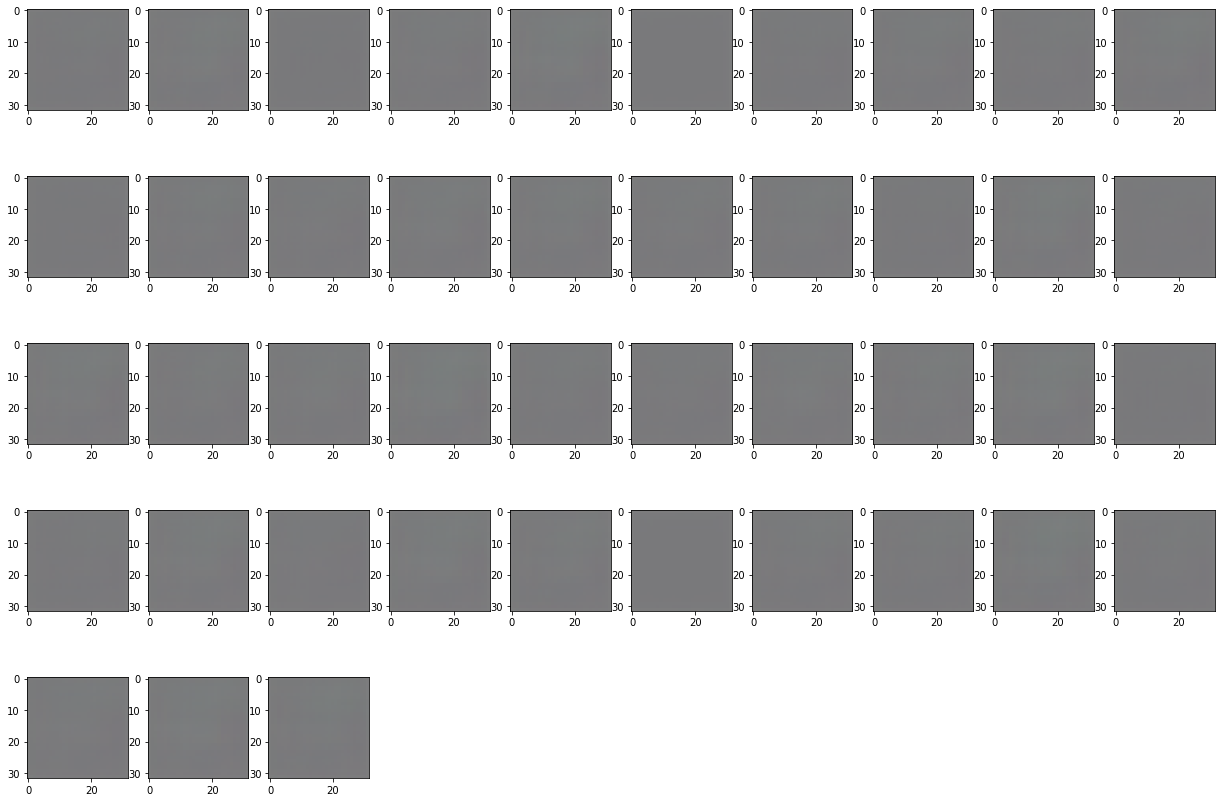

In [24]:
all_data = np.concatenate((X_train, X_test), axis=0)
all_data_features = autoencoder.predict(all_data)
all_data_features=all_data_features.reshape((len(all_data_features), np.prod(all_data_features.shape[1:])))
# apply kmeans to get the clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=43, random_state=0).fit(all_data_features)
# This is how our centroids look like
import matplotlib.pyplot as plt
dist_cols = 10
dist_rows = 7
bottom = 0.35
plt.figure(figsize=(3 * dist_cols, 3 * dist_rows))
for i in range(43):
    plt.subplots_adjust(bottom)
    plt.subplot(dist_rows, dist_cols, i+1)
    plt.imshow(kmeans.cluster_centers_[i].reshape(32, 32, 3))
plt.show()
